In [1]:
# !pip install pydotplus

STEP 0: Importing all the required libraries, utilities and dependecies

In [2]:
from decisiontree import *
from svmUtil import svmClassifier
from rfUtil import rfClassifier
from lrUtil import adaboost_gridSearch_lrClassifier
from utils import remove_missing_data
from sklearn import tree
from StringIO import StringIO
import numpy as np
from os import system
import pandas as pd
from sklearn.metrics import confusion_matrix,mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib
from math import ceil
import pydotplus
from IPython.display import Image
from sklearn.metrics import accuracy_score

%matplotlib inline

matplotlib.style.use('ggplot')

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


STEP 1: Define all the required functions:
* Preprocessing the data
* Bivariate analysis
* Call all the classifier and ensemble
* Validation

In [3]:
def accuracyScore(finalData, testData, yPos):
    accuracy_scores = {}
    for key, val in finalData.iteritems():
        accuracy_scores[key] = accuracy_score(finalData[key], np.array([x[yPos] for x in testData]))
    return accuracy_scores

def preprocess(data,dependent):
    categorical_data = data.select_dtypes(include = ['O'])
    cont_data = data.select_dtypes(exclude = ['O'])
    fig = plt.figure(figsize = (15,20))
    rows = len(list(cont_data.columns.values))/2+1
    counter = 0
    for i in cont_data.columns.values:
        column = cont_data[i]
        ls = pd.DataFrame({i:column,'dependent':dependent})
        ax = fig.add_subplot(rows,2,counter+1)
        ls.groupby('dependent').hist(bins = 5,stacked = True,ax = ax)
        ax.legend()
        ax.set_title(i)
#         (xmin,xmax) = (min(ls[i].tolist()),max(ls[i].tolist()))
#         ax.set_title(i)
#         ax.hist([cont_data_true,cont_data_false],bins = 5,histtype = 'bar', stacked = True, range = [xmin,xmax],label = [1,0])
#         ax.legend()
        counter += 1
    rows = ceil(len(categorical_data.columns.values)/2.0)
    fig = plt.figure(figsize = (15,10))
    counter = 0
    for i in categorical_data.columns.values:
        column = categorical_data[i]
        ax = fig.add_subplot(rows,2,counter +1)
        ax.set_title(i)
        ax.legend()
        subplt = pd.DataFrame({i:column,'dependent':dependent})
        cts = subplt.groupby([i,dependent]).size()
        cts.unstack.T.plot(kind = 'bar',ax = x,stacked = True,alpha = 0.5)
        counter += 1
    plt.show()

def replace_groups(data):
    a,b,c, = np.unique(data, True, True)
    _, ret = np.unique(b[c], False, True)
    return ret


In [4]:
def main(fileName):
    # remove missing row if all nan in a row, replace if null, empty strings
    # remove_missing_data(fileName, None, None)
    dataset_pd = pd.read_csv(fileName)
    for i in dataset_pd.columns.values[:-1]:
        h= sorted(dataset_pd[i].tolist())
        plt.hist(h)
        plt.show()
    preprocess(dataset_pd.drop(dataset_pd.columns.values[dataset_pd.shape[1]-1],axis = 1),dataset_pd.iloc[:,dataset_pd.shape[1]-1])

#     load and divide dataset into finaltest data and train data
    
    dataset = np.genfromtxt(open(fileName, 'r'), delimiter=',')[1:]
    dataset[:,-1] = replace_groups(dataset_pd.iloc[:,dataset_pd.shape[1]-1])
    testData = dataset[:int(0.3 * dataset.shape[0])]
    trainData = dataset[int(0.3 * dataset.shape[0]):]
    
    # final dataset to train for ann
    finalData = {};

    # for svm get the gamma, c and kernel using grid_search
    finalData = {}
    predicted = {}
    # svm
    finalData['svm'] = svmClassifier(trainData, testData, dataset.shape[1]-1, 'linear', 1, "auto")
    predicted['svm'] = finalData['svm'].predict([x[0:dataset.shape[1]-1] for x in testData])
    # random forest
    finalData['rf'] = rfClassifier(trainData, testData, dataset.shape[1]-1, 1000, 10)
    predicted['rf'] = finalData['rf'].predict([x[0:dataset.shape[1]-1] for x in testData])
    # logistic regression
    finalData['ada'] = adaboost_gridSearch_lrClassifier(trainData, testData, dataset.shape[1]-1)
    predicted['ada'] = finalData['ada'].predict([x[0:dataset.shape[1]-1] for x in testData])
    # ann on final result
    accuracy_scores = accuracyScore(predicted,testData,dataset.shape[1]-1)
    plt.bar(range(len(accuracy_scores)),accuracy_scores.values())
    plt.xticks(range(len(accuracy_scores)),accuracy_scores.keys())
    plt.title('Accuracy Scores')
    plt.show()
    tree_out = decision_tree_classifier(trainData[:, :dataset.shape[1]-1], trainData[:,dataset.shape[1]-1])
    finalData['tree'] = tree_out
    tree.export_graphviz(tree_out, out_file='tree.dot')
    return finalData

def user_input_data(dtree2,feature_names,tree1):
    # remove missing row if all nan in a row, replace if null, empty strings
    # remove_missing_data(fileName, None, None)


    # load and divide dataset into finaltest data and train data
    unmatched_node = compare_trees(dtree2,tree1,feature_names)
    return unmatched_node

STEP 2: Modelling
* Univariate Analysis
* Bivariate Analysis
* Build the base model

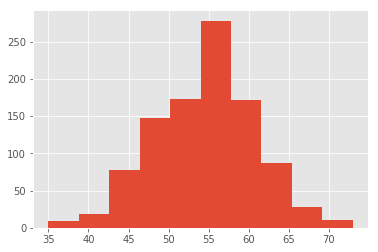

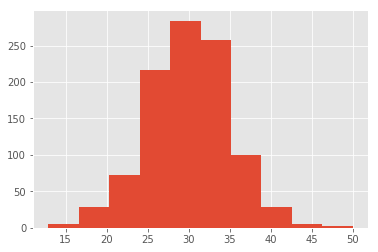

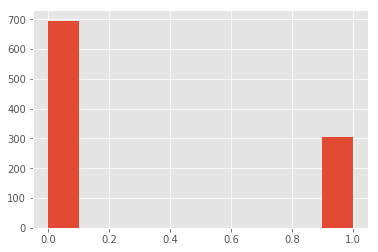

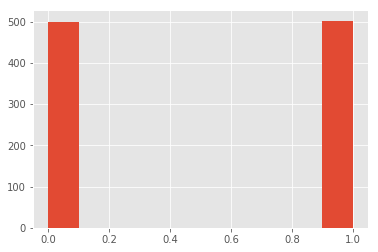

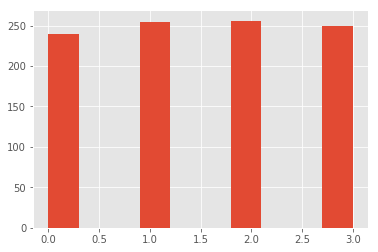

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


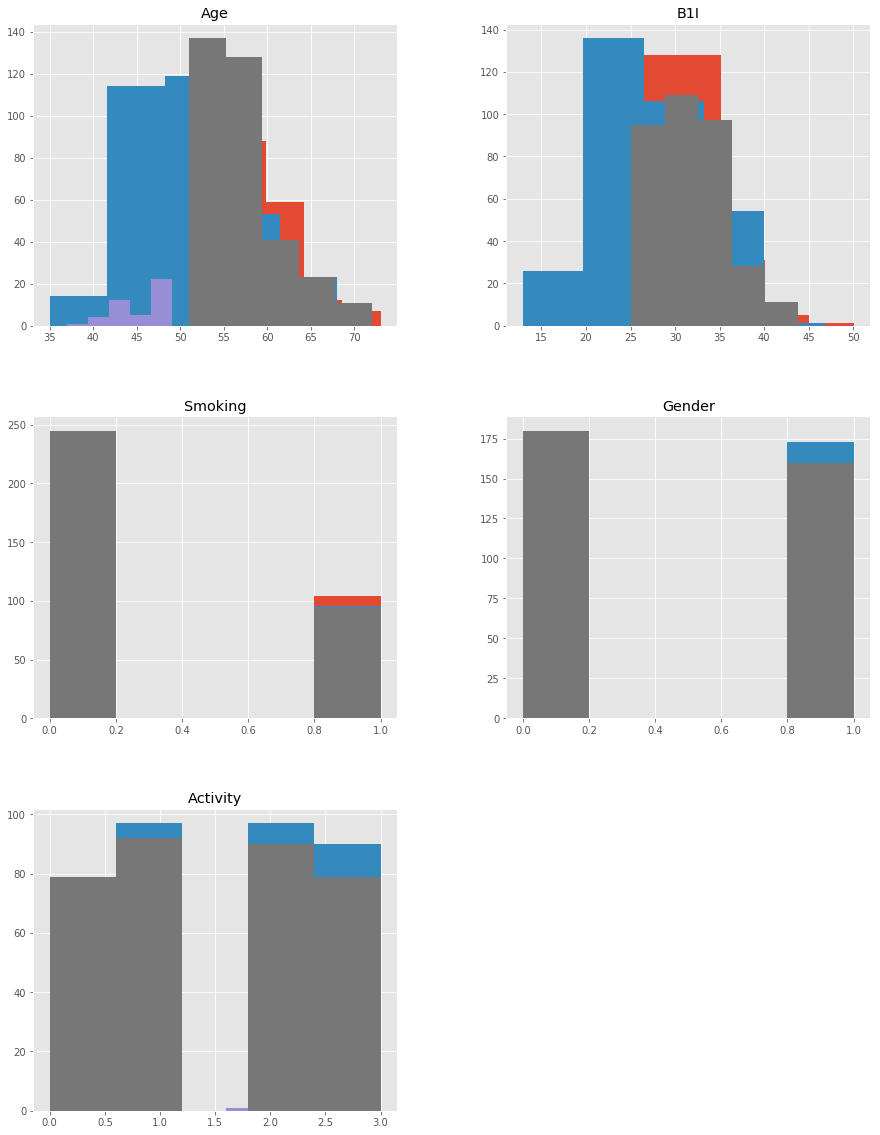

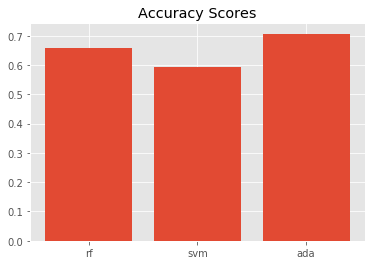

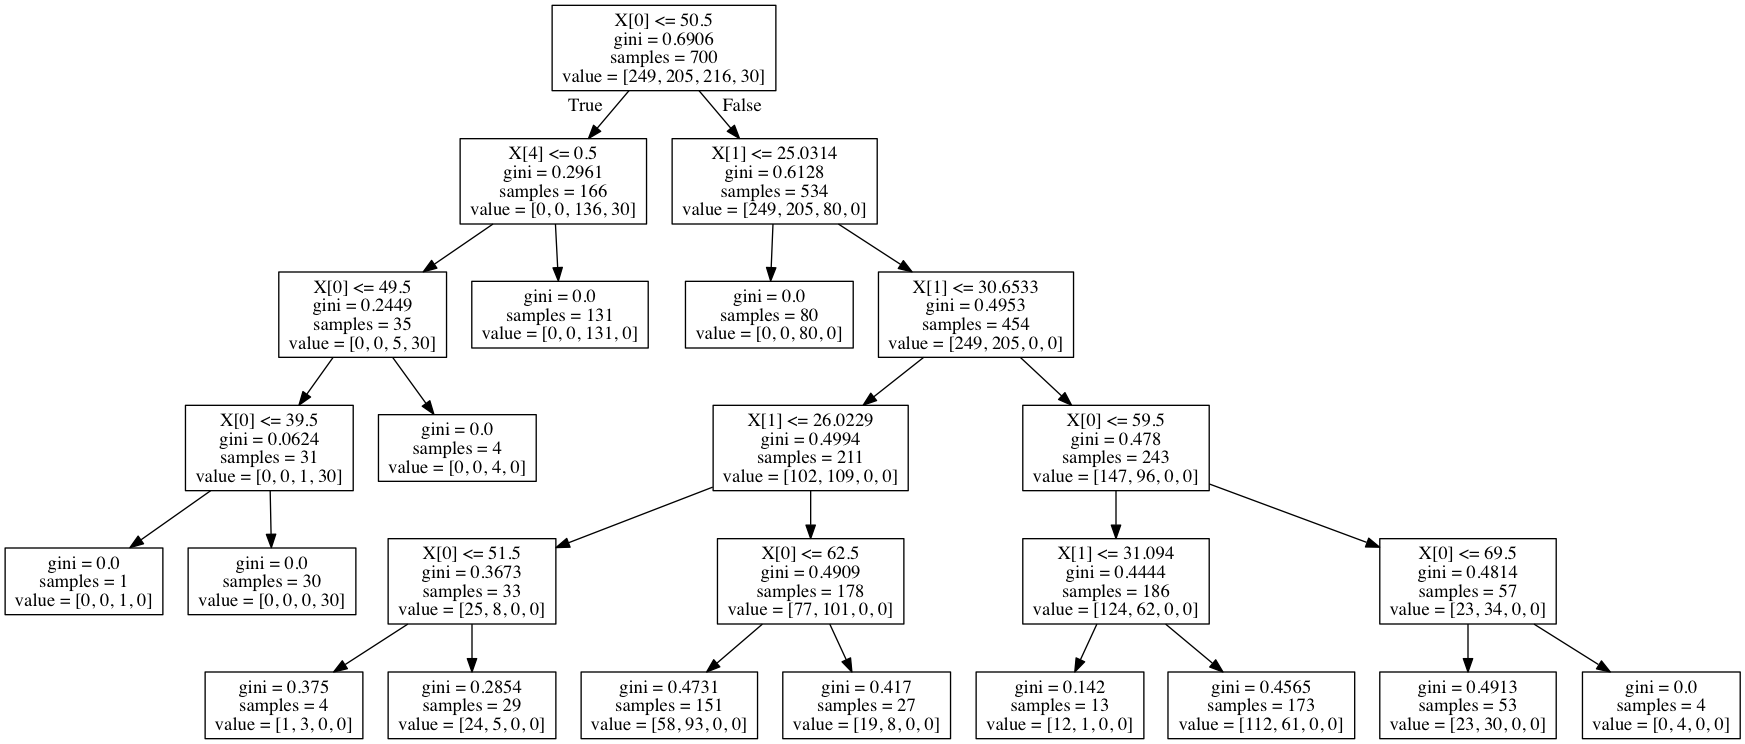

In [5]:
output_1 =  main('./data/4classes.csv')
out = StringIO()
dot_data = tree.export_graphviz(output_1['tree'], out_file='out.dot')
system('dot -Tpng -o out.png out.dot')
Image('out.png')

![title](out.png)

STEP 3:
* For a new patient, identify the optimal care according to the protocol

In [ ]:
def predict(finalData,inputData)
    return sum([finalData[i].predict(inputData) for i in finalData.keys()])/float(len(finalData.keys))

STEP 3: Reinforcment
* Add new data
* Incorporate feedback
* Rebuild the model
* Measure the deviation from existing model

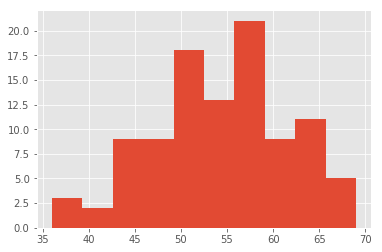

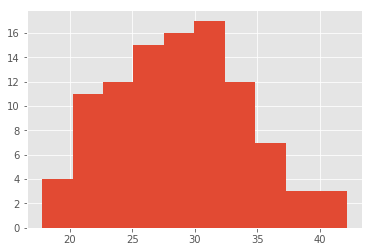

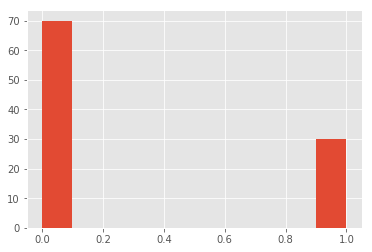

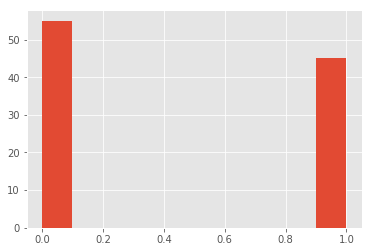

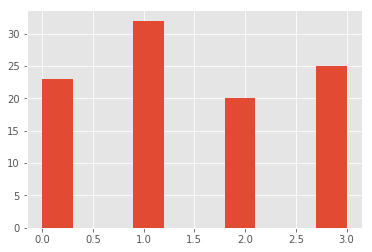

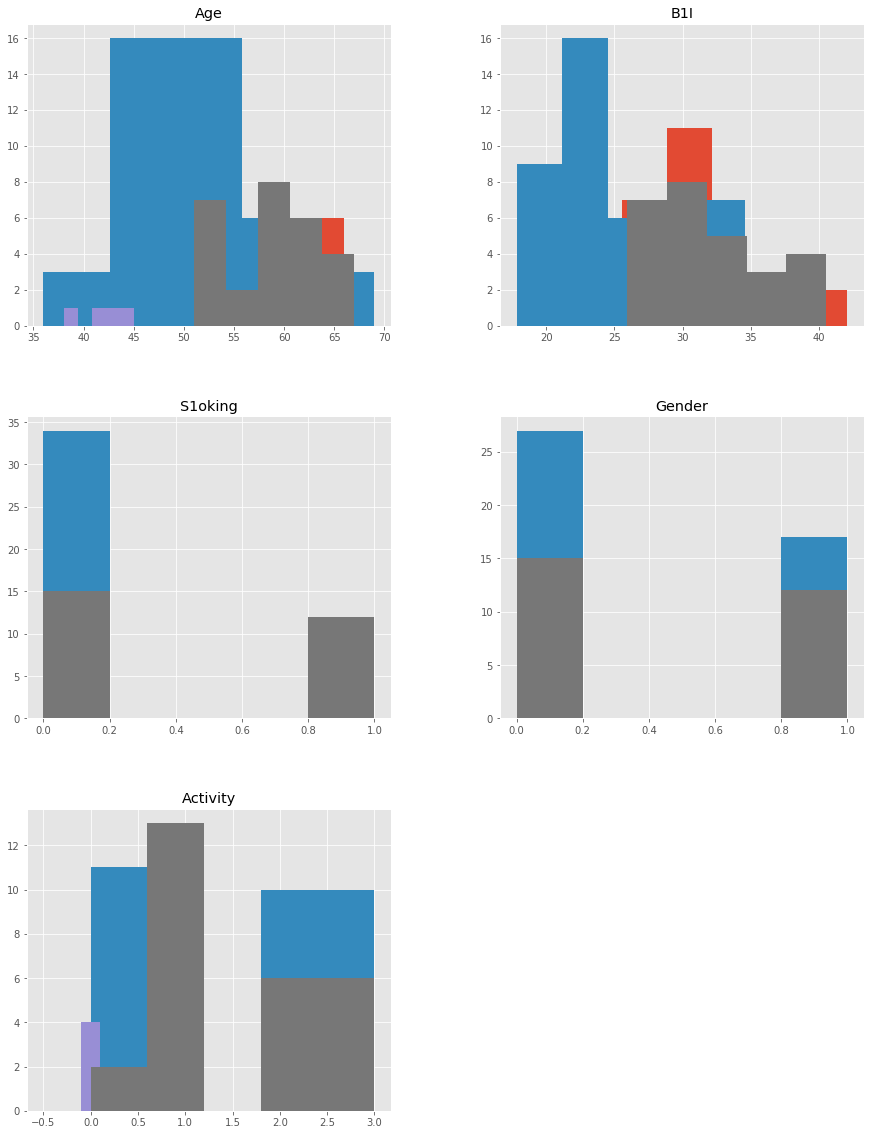

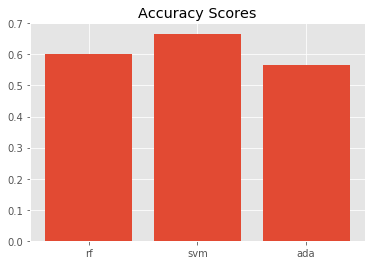

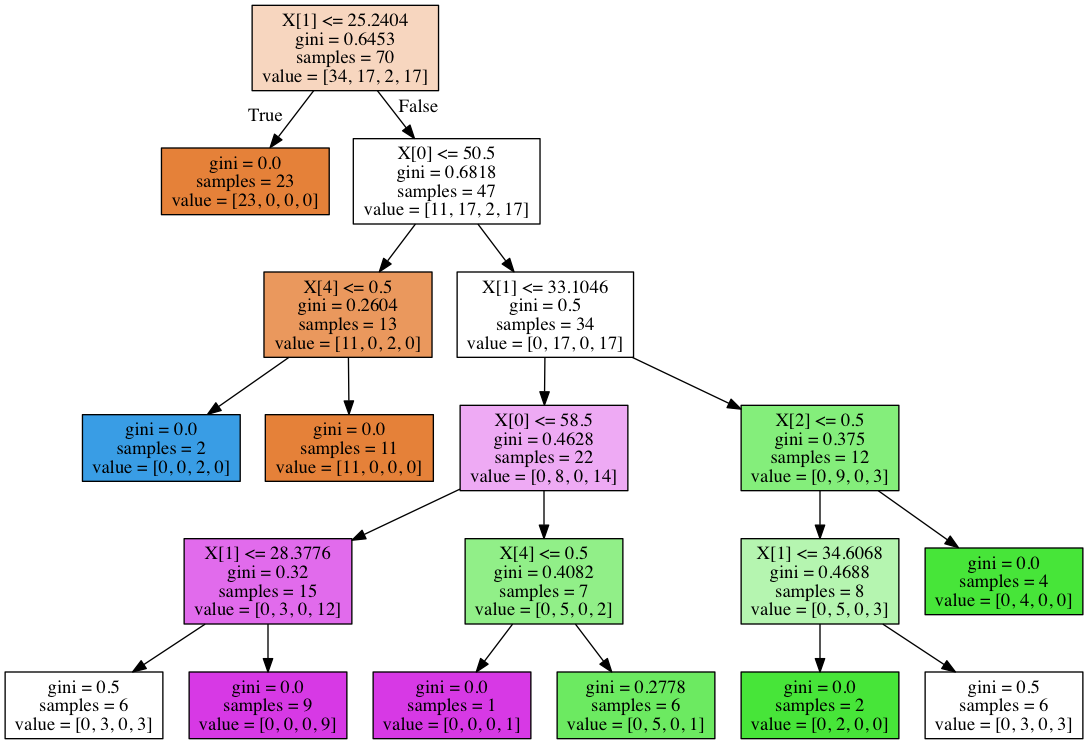

In [6]:
output_2 =  main('./data/r4classes.csv')
feature_names = ["Age","BMI","Smoking", "Gender", "Activity" , "Diagnosis"]
unmatched_node = user_input_data(output_2['tree'],feature_names,output_1['tree'])
tree.export_graphviz(output_2['tree'], out_file='tree2.dot',filled=True)
system('dot -Tpng -o tree2.png tree2.dot')
Image('tree2.png')

![title](tree2.png)

Contionus Montoring: Identify deviations and generate reports

In [ ]:
anomalies =  segmentation(pd.read_csv('./data/4classes.csv').drop('Diagnosis',axis = 1))
print "The following points are found to be anamolous, please check them:"
print anomalies
anomalies.to_csv('anomalies.csv')